In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')



Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/315_Birds_Species.zip' -d '/content/'

Loading libraries:

In [3]:
import os
from keras.preprocessing import image

import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten

Data Pre-processing:

In [ ]:
train="/content/train" 
test="/content/test"
valid="/content/valid"

In [ ]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [ ]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

In [ ]:
train_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
valid_generator=ImageDataGenerator( preprocessing_function=preprocess_input)


Data Augmentation:

In [ ]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=16,
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = valid_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32
)

Found 45980 validated image filenames belonging to 315 classes.
Found 1575 validated image filenames belonging to 315 classes.
Found 1575 validated image filenames belonging to 315 classes.


*The dataset has 315 bird species meaning that there are 315 different classes or outputs we would like to predict with the trained model.*

GradCam visualization functions to demonstrate in the form of heat map
where in the image the CNN is looking at while making prediction:

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# RESNET50 with Transfer Learning

In [ ]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our choice

outputs = Dense(315, activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

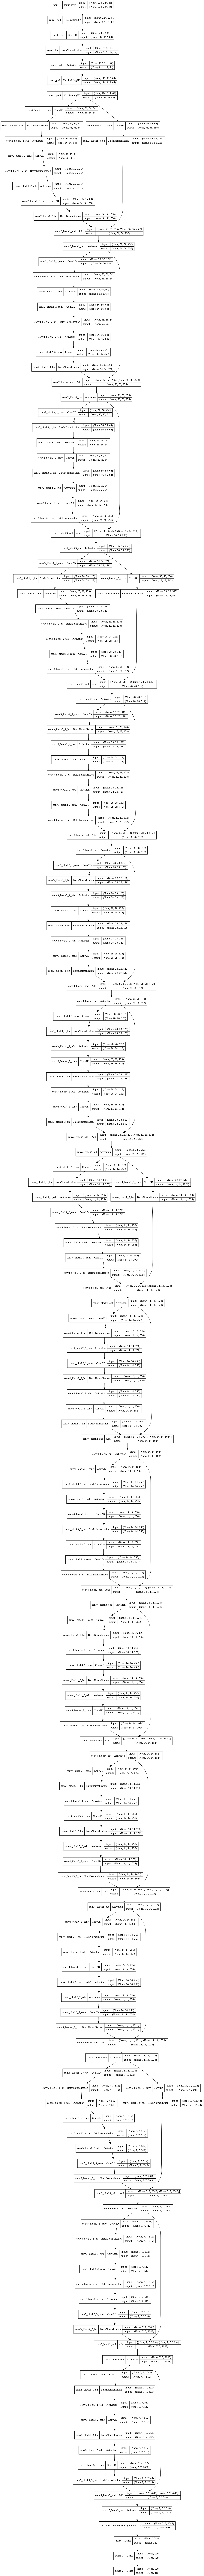

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_layer_names=True, show_shapes=True)

In [ ]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Colab Notebooks/RESNET50.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history = model.fit( train_image,validation_data=valid_image,epochs=5,        
        callbacks = callbacks_list,
        verbose = 1)

Epoch 1/5
2874/2874 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9294
Epoch 00001: val_loss improved from inf to 0.29615, saving model to /content/drive/MyDrive/Colab Notebooks/RESNET50.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2874/2874 [==============================] - 375s 130ms/step - loss: 0.2355 - accuracy: 0.9294 - val_loss: 0.2962 - val_accuracy: 0.9238
Epoch 2/5
2874/2874 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9340
Epoch 00002: val_loss did not improve from 0.29615
2874/2874 [==============================] - 370s 129ms/step - loss: 0.2165 - accuracy: 0.9340 - val_loss: 0.3661 - val_accuracy: 0.9162
Epoch 3/5
2874/2874 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9393
Epoch 00003: val_loss did not improve from 0.29615
2874/2874 [==============================] - 367s 128ms/step - loss: 0.2039 - accuracy: 0.9393 - val_loss: 0.4374 - val_accuracy: 0.8946
Epoch 4/5
2874/2874 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9449
Epoch 00004: val_loss did not improve from 0.29615
2874/2874 [==============================] - 367s 128ms/step - loss: 0.1841 - accuracy: 0.9449 - val_loss: 0.4191 - val_accuracy: 0.9029
Epoch 5/

In [ ]:
from tensorflow.keras.models import load_model
# Load the best saved model
resnet_model = load_model('/content/drive/MyDrive/Colab Notebooks/RESNET50.h5')

In [ ]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# hist_df = pd.DataFrame(history.history) 
np.save('/content/drive/MyDrive/Colab Notebooks/RESNET50_history.npy',history.history)

In [5]:
history_dict=np.load('/content/drive/MyDrive/Colab Notebooks/RESNET50_history.npy',allow_pickle='TRUE').item()

Training Graphs:

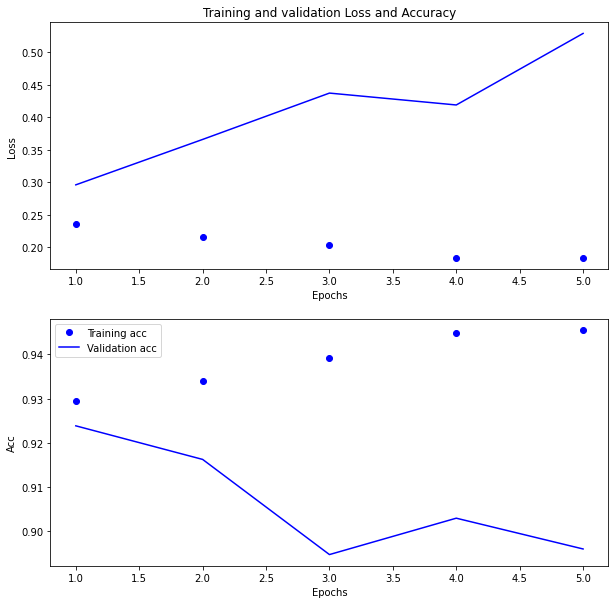

In [6]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

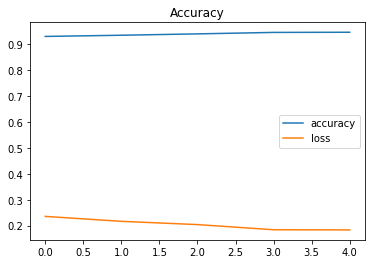

In [ ]:
pd.DataFrame(history)[['accuracy','loss']].plot()
plt.title("Accuracy")
plt.show()


Confusion Matrix:

In [ ]:

Y_pred = model.predict(test_image)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_image.labels, y_pred))


Confusion Matrix
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
model.evaluate(test_image)

50/50 [==============================] - 12s 218ms/step - loss: 0.2137 - accuracy: 0.9384


[0.21366451680660248, 0.9384127259254456]

In [ ]:
resnet_model.evaluate(test_image)

50/50 [==============================] - 260s 5s/step - loss: 12.8185 - accuracy: 0.9384


[12.81851577758789, 0.9384127259254456]

Few of the correctly and incorrectly classified
images:




In [ ]:
dic=train_image.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=image.load_img(location,target_size=(224,224,3))
    img=image.img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=np.argmax(resnet_model.predict(img), axis=-1)
    probability=round(np.max(resnet_model.predict(img)*100),2)
    print ('Bird Is',icd[answer[0]], 'With probability',probability)
    print (probability, ' % chances are there that the Bird Is',icd[answer[0]])

Bird Is HOUSE FINCH With probability 43.17
43.17  % chances are there that the Bird Is HOUSE FINCH


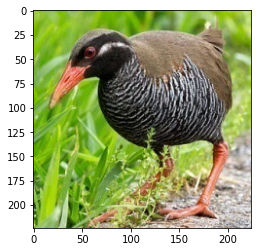

In [ ]:
img='/content/test/OKINAWA RAIL/2.jpg' 
pic=image.load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

57.58  % chances are there that the Bird Is HOUSE FINCH


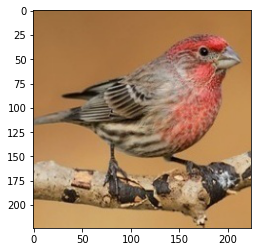

In [ ]:

img='/content/test/HOUSE FINCH/2.jpg' 
pic=image.load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

Heatmap:

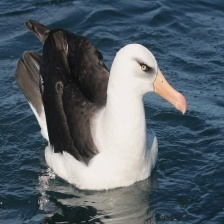

In [ ]:
last_conv_layer_name = "conv5_block3_3_conv"

# The local path to our target image
img_path = keras.utils.get_file(
    "/content/train/ALBATROSS/001.jpg", "https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

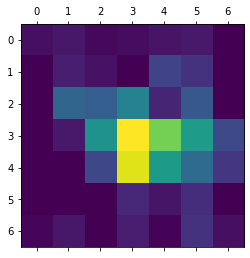

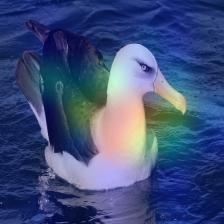

In [ ]:
# Prepare image
img_size = (224, 224)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model

# Remove last layer's softmax
resnet_model.layers[-1].activation = None

# Print what the top predicted class is
preds = resnet_model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, resnet_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)

# VGG16 with Transfer Learning

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
#eff_model.summary()
vgg_model.trainable = False

layer0 = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
layer1 = tf.keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
layer2 = tf.keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)
out_layer = tf.keras.layers.Dense(315, activation='softmax')(layer2)
vgg_model = tf.keras.Model(vgg_model.input, out_layer)
vgg_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
              #,
              #ModelCheckpoint(filepath='Fullmodel.{epoch:02d}-{acc:.2f}.h5', monitor='val_acc', save_best_only=False, mode='max')]
             ]

In [ ]:

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Colab Notebooks/VGG16.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history_vgg16 = vgg_model.fit(
      train_image, 
      epochs=5,
      verbose=1,
      validation_data = valid_image,
      callbacks=callbacks_list)

Epoch 1/5
2874/2874 [==============================] - ETA: 0s - loss: 2.8545 - accuracy: 0.5724
Epoch 00001: val_loss improved from inf to 0.76474, saving model to /content/drive/MyDrive/Colab Notebooks/VGG16.h5
2874/2874 [==============================] - 561s 193ms/step - loss: 2.8545 - accuracy: 0.5724 - val_loss: 0.7647 - val_accuracy: 0.8222
Epoch 2/5
2874/2874 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.8614
Epoch 00002: val_loss improved from 0.76474 to 0.64509, saving model to /content/drive/MyDrive/Colab Notebooks/VGG16.h5
2874/2874 [==============================] - 558s 194ms/step - loss: 0.6370 - accuracy: 0.8614 - val_loss: 0.6451 - val_accuracy: 0.8705
Epoch 3/5
2874/2874 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 0.9068
Epoch 00003: val_loss did not improve from 0.64509
2874/2874 [==============================] - 505s 176ms/step - loss: 0.4374 - accuracy: 0.9068 - val_loss: 0.9094 - val_accuracy: 0.8438
Epoch 4/5
2

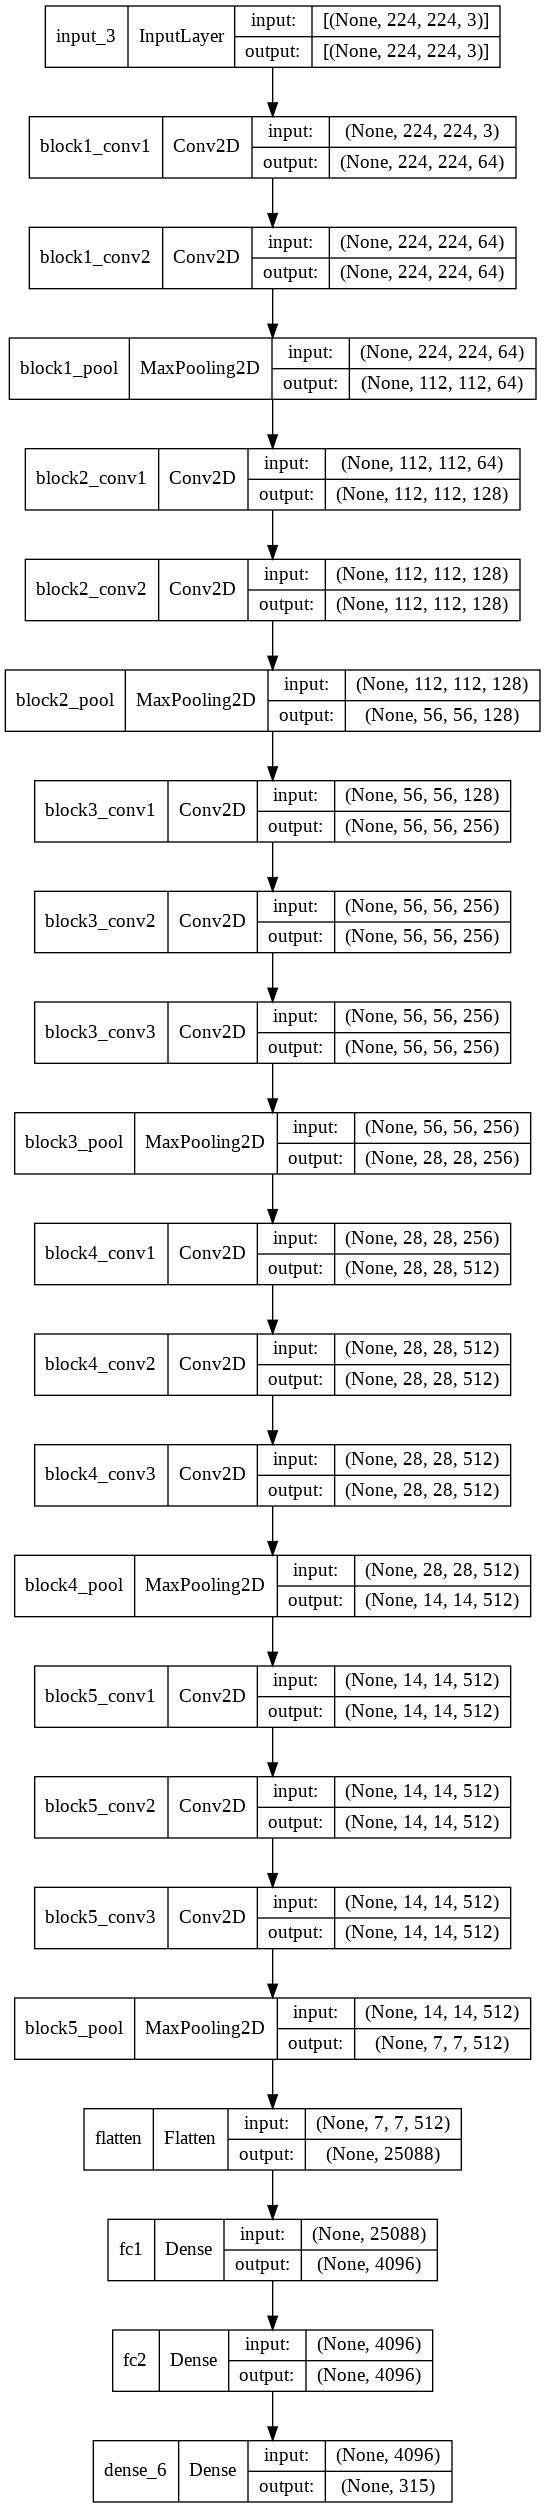

In [8]:
from tensorflow.keras.models import load_model
vgg_model = load_model('/content/drive/MyDrive/Colab Notebooks/VGG16.h5')
tf.keras.utils.plot_model(
    vgg_model, to_file='model1.png', show_layer_names=True, show_shapes=True)


In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/VGG16_history.npy',history_vgg16.history)


In [9]:
history_dict=np.load('/content/drive/MyDrive/Colab Notebooks/VGG16_history.npy',allow_pickle='TRUE').item()

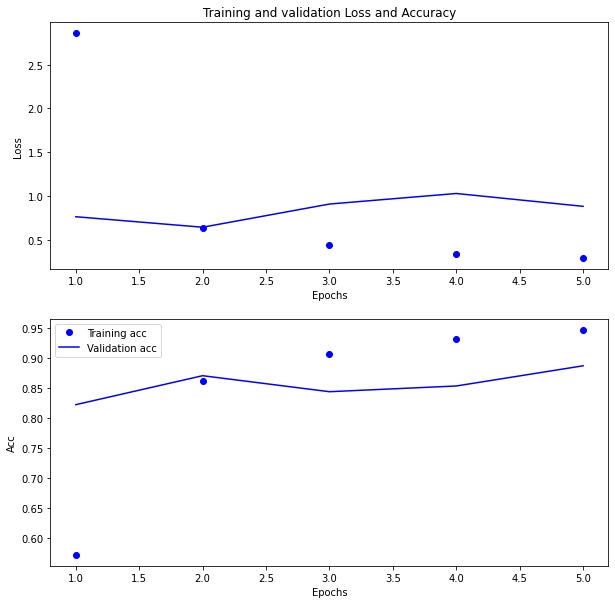

In [11]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
vgg_model.evaluate(test_image,use_multiprocessing=True,workers=10)

50/50 [==============================] - 29s 317ms/step - loss: 0.5266 - accuracy: 0.8825


[0.526616096496582, 0.882539689540863]

In [ ]:
y_pred
cm=confusion_matrix(y_real, y_pred)
cm

[[  3  65]
 [ 78  65]
 [ 58  65]
 ...
 [148   2]
 [135   2]
 [242   2]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
dic=train_image.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=image.load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=np.argmax(vgg_model.predict(img), axis=-1)
    probability=round(np.max(vgg_model.predict(img)*100),2)
    #print ('Bird Is',icd[answer[0]], 'With probability',probability)
    print (probability, ' % chances are there that the Bird Is',icd[answer[0]])

Few of the correctly and incorrectly classified
images:

0.68  % chances are there that the Bird Is TRUMPTER SWAN


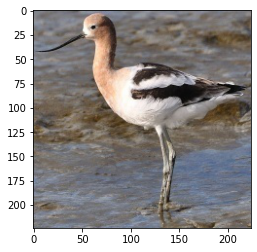

In [ ]:
img='/content/test/AMERICAN AVOCET/1.jpg' 
pic=image.load_img('/content/test/AMERICAN AVOCET/1.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

0.87  % chances are there that the Bird Is SAND MARTIN


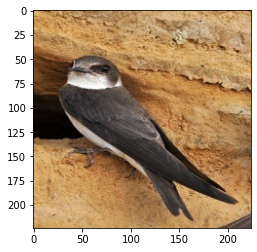

In [ ]:
img='/content/test/SAND MARTIN/1.jpg' 
pic=image.load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

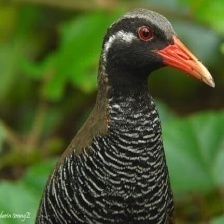

In [ ]:
last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = keras.utils.get_file(
    "/content/test/OKINAWA RAIL/1.jpg", "https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

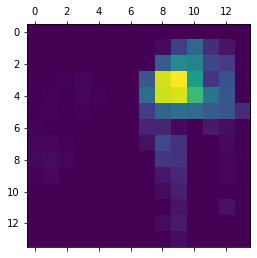

In [ ]:
# Prepare image
img_size = (224, 224)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model

# Remove last layer's softmax
vgg_model.layers[-1].activation = None

# Print what the top predicted class is
preds = vgg_model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, vgg_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

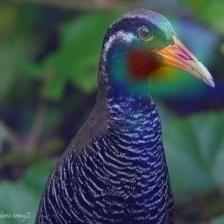

In [ ]:
save_and_display_gradcam(img_path, heatmap)

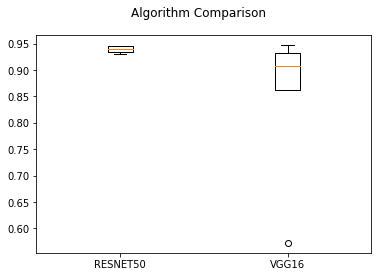

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# # load dataset
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# dataframe = pandas.read_csv(url, names=names)
# array = dataframe.values
# X = array[:,0:8]
# Y = array[:,8]
# # prepare configuration for cross validation test harness
# seed = 7
# # prepare models
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/RESNET50.h5')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/VGG16.h5')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/VGG16.h5')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/VGG16.h5')

models = []
models.append(('RESNET50', model1))
models.append(('VGG16', model2))

# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	his=np.load('/content/drive/MyDrive/Colab Notebooks/'+name+'_history.npy',allow_pickle='TRUE').item()
	results.append(his['accuracy'])
	names.append(name)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()